<a href="https://colab.research.google.com/github/mashruravi/eip-hvc/blob/master/colab/best_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
!cp /content/gdrive/My\ Drive/hvc_encoded_3.csv /content/
# `hvc_encoded.csv` and `resized` should be available
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
gdrive/              hvc_encoded_3.csv  resized/
hvc_annotations.csv  model.h5           sample_data/


In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('hvc_encoded_3.csv')
df.head()

,image_path,gender_female,gender_male,qual_Average,qual_Bad,qual_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,bag_Daily/Office/Work Bag,bag_Grocery/Home/Plastic Bag,bag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.15)

In [0]:
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
# Columns for one-hot encoded labels
def get_columns_by_prefix(prefix):
  return [col for col in df if col.startswith(prefix)]

_gender_columns = get_columns_by_prefix('gender')
_qual_columns_ = get_columns_by_prefix('qual')
_age_columns_ = get_columns_by_prefix('age')
_weight_columns_ = get_columns_by_prefix('weight')
_bag_columns_ = get_columns_by_prefix('bag')
_footwear_columns_ = get_columns_by_prefix('footwear')
_emotion_columns_ = get_columns_by_prefix('emotion')
_bodypose_columns_ = get_columns_by_prefix('bodypose')

In [0]:
import tensorflow
print(tensorflow.__version__)

1.15.0


In [0]:
import keras
import numpy as np
import cv2
from __future__ import division

class DataGenerator(tensorflow.keras.utils.Sequence):
  
  def __init__(self, df, batch_size=32, shuffle=True):
    self.df = df
    self.batch_size = batch_size
    self.shuffle = shuffle

  def __len__(self):
    return int(np.ceil(self.df.shape[0] / self.batch_size))

  def __getitem__(self, index):
    """ return X=224,224,3,batch_size and y=num_classes,batch_size"""
    batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
    items = self.df.iloc[batch_slice]
    images = np.stack([cv2.imread(item['image_path']) for _, item in items.iterrows()])
    images = images/255
    target = {
        'gender_output': items[_gender_columns].values,
        'imagequality_output': items[_qual_columns_].values,
        'age_output': items[_age_columns_].values,
        'weight_output': items[_weight_columns_].values,
        'bag_output': items[_bag_columns_].values,
        'footwear_output': items[_footwear_columns_].values,
        'emotion_output': items[_emotion_columns_].values,
        'bodypose_output': items[_bodypose_columns_].values
    }
    return images, target

  def on_epoch_end(self):
    """Shuffle data after each epoch"""
    if self.shuffle == True:
      self.df = self.df.sample(frac=1).reset_index(drop=True)

In [0]:
BATCH_SIZE=16
train_gen = DataGenerator(train_df, batch_size=BATCH_SIZE, shuffle=True)
valid_gen = DataGenerator(val_df, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
images, targets = next(iter(train_gen))

In [0]:
def get_unit_count(value_output):
  if (len(value_output.shape) > 1):
    return value_output.shape[1]
  else:
    return 1
num_units = { k.split("_output")[0]: get_unit_count(v) for k, v in targets.items() }
num_units

{'age': 5,
 'bag': 3,
 'bodypose': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'imagequality': 3,
 'weight': 4}

In [0]:
from __future__ import division

import six
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    GlobalAveragePooling2D
)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


weight_decay = 0.005

def initial_conv(input, i):
    x = Conv2D(100, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name=f"conv_init_{i}")(input)

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name=f"BN_init_{i}")(x)
    x = Activation('relu')(x)
    return x


def expand_conv(idx, init, base, k, strides=(1, 1)):
    x = Conv2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_expand_"+str(idx)+"_1")(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN_expand"+str(idx))(x)
    x = Activation('relu')(x)

    x = Conv2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_expand_"+str(idx)+"_2")(x)

    skip = Conv2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_expand_"+str(idx)+"_3")(init)

    m = add([x, skip])

    return m


def conv1_block(idx, input, k=1, dropout=0.0):
    init = input

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN1_"+str(idx)+"_1")(input)
    x = Activation('relu')(x)
    x = Conv2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv1_"+str(idx)+"_1")(x)

    if dropout > 0.0: x = Dropout(rate=dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN1_"+str(idx)+"_2")(x)
    x = Activation('relu')(x)
    x = Conv2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv1_"+str(idx)+"_2")(x)

    m = add([init, x])
    return m

def conv2_block(idx, input, k=1, dropout=0.0):
    init = input

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN2_"+str(idx)+"_1")(input)
    x = Activation('relu')(x)
    x = Conv2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv2_"+str(idx)+"_1")(x)

    if dropout > 0.0: x = Dropout(rate=dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN2_"+str(idx)+"_2")(x)
    x = Activation('relu')(x)
    x = Conv2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False,name="conv2_"+str(idx)+"_2")(x)

    m = add([init, x])
    return m

def conv3_block(idx, input, k=1, dropout=0.0):
    init = input

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN3_"+str(idx)+"_1")(input)
    x = Activation('relu')(x)
    x = Conv2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv3_"+str(idx)+"_1")(x)

    if dropout > 0.0: x = Dropout(rate=dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN3_"+str(idx)+"_2")(x)
    x = Activation('relu')(x)
    x = Conv2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv3_"+str(idx)+"_2")(x)

    m = add([init, x])
    return m

def create_wide_residual_network(input_layer, N=2, k=1, dropout=0.0, verbose=1, index=0):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = input_layer

    x = initial_conv(ip, index)
    nb_conv = 4

    x = expand_conv(f"{index}_1", x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(f"{index}_i", x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name=f"BN_{index}_1")(x)
    x = Activation('relu')(x)

    x = expand_conv(f"{index}_2", x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(f"{index}_i", x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name=f"BN_{index}_2")(x)
    x = Activation('relu')(x)

    x = expand_conv(f"{index}_3", x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(f"{index}_i", x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name=f"BN_{index}_3")(x)
    x = Activation('relu')(x)

    return x

    # x = Conv2D(nb_classes, (1,1), padding="same", name="conv_final")(x)
    # x = GlobalAveragePooling2D(name="GAP")(x)
    # x = Activation("softmax")(x)

    # model = Model(ip, x)

    # if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    # return model

In [0]:
weight_decay=0.005
from keras.models import Model, Sequential
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from keras.layers import (
    Convolution2D,
    MaxPooling2D,
    AveragePooling2D,
    GlobalAveragePooling2D
)
from keras.layers import add
from keras.layers import BatchNormalization

def conv_bn_relu(backbone, filters):
  backbone.add(Convolution2D(filters, (3, 3), dilation_rate=(2, 2)))
  backbone.add(BatchNormalization())
  backbone.add(Activation('relu'))
  backbone.add(Dropout(0.2))

def get_backbone(backbone):
  backbone.add(Convolution2D(16, (3, 3),dilation_rate=(2, 2),input_shape=(224, 224, 3)))
  backbone.add(BatchNormalization())
  backbone.add(Activation('relu'))
  backbone.add(Dropout(0.2))
  conv_bn_relu(backbone, 16)

  conv_bn_relu(backbone, 32)
  conv_bn_relu(backbone, 32)

  conv_bn_relu(backbone, 48)
  conv_bn_relu(backbone, 48)

  conv_bn_relu(backbone, 64)
  conv_bn_relu(backbone, 64)

  conv_bn_relu(backbone, 96)
  conv_bn_relu(backbone, 96)

  conv_bn_relu(backbone, 128)
  backbone.add(GlobalAveragePooling2D())

def get_neck(input_layer, index):
  return input_layer
  # x = GlobalAveragePooling2D()(x)
  # x = Flatten()(x)
  # x = Dropout(rate=0.2)(x)
  # x = Dense(32, activation='sigmoid')(x)
  # x = Dropout(rate=0.2)(x)
  # x = Dense(64, activation='sigmoid')(x)
  # return x

def get_head(name, input_layer):
  return Dense(num_units[name], activation='softmax', name=f'{name}_output')(input_layer)

def make_model():

  backbone = Sequential()

  get_backbone(backbone)


  # heads
  age = get_head('age', get_neck(backbone.output, 1))
  bag = get_head('bag', get_neck(backbone.output, 2))
  bodypose = get_head('bodypose', get_neck(backbone.output, 3))
  emotion = get_head('emotion', get_neck(backbone.output, 4))
  footwear = get_head('footwear', get_neck(backbone.output, 5))
  gender = get_head('gender', get_neck(backbone.output, 6))
  imagequality = get_head('imagequality', get_neck(backbone.output, 7))
  weight = get_head('weight', get_neck(backbone.output, 8))

  model = Model(
      inputs = backbone.input,
      outputs = age
      # outputs = [age, bag, bodypose, emotion, footwear, gender, imagequality, weight]
  )
  

  return model

In [0]:
def get_compiled_model():

  model = make_model()

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      # loss={
      #     # 'gender_output': 'categorical_crossentropy',
      #     # 'imagequality_output': 'categorical_crossentropy',
      #     'age_output': 'categorical_crossentropy',
      #     # 'weight_output': 'categorical_crossentropy',
      #     # 'bag_output': 'categorical_crossentropy',
      #     # 'footwear_output': 'categorical_crossentropy',
      #     # 'emotion_output': 'categorical_crossentropy',
      #     # 'bodypose_output': 'categorical_crossentropy'
      # },
      metrics=["accuracy"]
  )
  return model


In [55]:
model = get_compiled_model()
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_167_input (InputLayer (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 220, 220, 16)      448       
_________________________________________________________________
batch_normalization_155 (Bat (None, 220, 220, 16)      64        
_________________________________________________________________
activation_155 (Activation)  (None, 220, 220, 16)      0         
_________________________________________________________________
dropout_156 (Dropout)        (None, 220, 220, 16)      0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 216, 216, 16)      2320      
_________________________________________________________________
batch_normalization_156 (Bat (None, 216, 216, 16)      64 

In [0]:
from tensorflow.keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
clr = CyclicLR(base_lr=1e-12, max_lr=.1, step_size=14421)

In [56]:
# clr = CyclicLR(base_lr=0.000001, max_lr=.1, step_size=5776)
model2 = get_compiled_model()
train_gen = DataGenerator(train_df, batch_size=BATCH_SIZE, shuffle=True)
history = model2.fit_generator(
    generator=train_gen,
    # validation_data=valid_gen,
    epochs=100,
    # class_weight={
    #     0: 1.15,
    #     1: 0.49,
    #     2: 0.82,
    #     3: 1.65,
    #     4: 3.88
    # },
    # callbacks=[clr]
)

Epoch 1/100
267/722 [==========>...................] - ETA: 3:43 - loss: 1.4530 - acc: 0.3881

KeyboardInterrupt: ignored

In [65]:
print(keras.__version__)

2.2.5


In [89]:
from keras.models import Model, Sequential
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from keras.layers import (
    Convolution2D,
    MaxPooling2D,
    AveragePooling2D,
    GlobalAveragePooling2D
)
from keras.layers import add
from keras.layers import BatchNormalization
from keras.regularizers import l2
regularization_strength=0.0001


backbone = Sequential()
# 1st set of Conv + Relu
backbone.add(Convolution2D(16, (3, 3),dilation_rate=(2, 2),input_shape=(224, 224, 3))) #220
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 2nd set of Conv + Relu
backbone.add(Convolution2D(16, (3, 3),strides=(2,2), kernel_regularizer=l2(regularization_strength))) #110
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 3rd set of Conv + Relu
backbone.add(Convolution2D(32, (3, 3),dilation_rate=(2, 2), kernel_regularizer=l2(regularization_strength))) #106
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 4th set of Conv + Relu
backbone.add(Convolution2D(32, 3, 3, kernel_regularizer=l2(regularization_strength))) #104
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 5th set of Conv + Relu
backbone.add(Convolution2D(48, (3, 3),strides=(2,2), kernel_regularizer=l2(regularization_strength))) #52
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 7th set of Conv + Relu
backbone.add(Convolution2D(48, (3, 3),dilation_rate=(2, 2), kernel_regularizer=l2(regularization_strength))) #48
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 8th set of Conv + Relu
backbone.add(Convolution2D(64, 3, 3, kernel_regularizer=l2(regularization_strength))) #46
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 9th set of Conv + Relu
backbone.add(Convolution2D(64, (3, 3),strides=(2,2), kernel_regularizer=l2(regularization_strength))) #23
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 10th set of Conv + Relu
backbone.add(Convolution2D(96, (3, 3),dilation_rate=(2, 2), kernel_regularizer=l2(regularization_strength))) #19
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 11th set of Conv + Relu
backbone.add(Convolution2D(96, (3, 3),strides=(2,2), kernel_regularizer=l2(regularization_strength))) #9
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))
# 12th set of Conv + Relu
backbone.add(Convolution2D(128, (3, 3),dilation_rate=(2, 2), kernel_regularizer=l2(regularization_strength))) #5
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))

backbone.add(Convolution2D(128, (3, 3), padding='same', kernel_regularizer=l2(regularization_strength)))
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))

backbone.add(Convolution2D(128, (3, 3), padding='same', kernel_regularizer=l2(regularization_strength)))
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))

backbone.add(Convolution2D(128, (3, 3), padding='same', kernel_regularizer=l2(regularization_strength)))
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.2))

backbone.add(GlobalAveragePooling2D(name='avg_pool'))
neck = backbone.output
# neck = Flatten(name="flatten")(neck)
# neck = Dense(512, activation="relu")(neck)
def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(neck)
    neck = Dense(128, activation="relu")(neck)
    return neck
def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)
# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("imagequality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("bodypose", build_tower(neck))
model = Model(
    inputs=backbone.input, 
    outputs=gender
    # outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg...)`


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_301_input (InputLayer (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 220, 220, 16)      448       
_________________________________________________________________
batch_normalization_288 (Bat (None, 220, 220, 16)      64        
_________________________________________________________________
activation_288 (Activation)  (None, 220, 220, 16)      0         
_________________________________________________________________
dropout_369 (Dropout)        (None, 220, 220, 16)      0         
_________________________________________________________________
conv2d_302 (Conv2D)          (None, 109, 109, 16)      2320      
_________________________________________________________________
batch_normalization_289 (Bat (None, 109, 109, 16)      64 

In [0]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [91]:
train_gen = DataGenerator(train_df, batch_size=BATCH_SIZE, shuffle=True)
val_gen = DataGenerator(val_df, batch_size=BATCH_SIZE, shuffle=False)
history = model.fit_generator(
  generator=train_gen,
  validation_data=val_gen,
  epochs=20
)

Epoch 1/20
722/722 [==============================] - 64s 89ms/step - loss: 0.7572 - acc: 0.5788 - val_loss: 0.7396 - val_acc: 0.6066
Epoch 2/20
722/722 [==============================] - 48s 66ms/step - loss: 0.7157 - acc: 0.6182 - val_loss: 1.0618 - val_acc: 0.5702
Epoch 3/20
722/722 [==============================] - 48s 66ms/step - loss: 0.6844 - acc: 0.6419 - val_loss: 0.7045 - val_acc: 0.6336
Epoch 4/20
722/722 [==============================] - 48s 66ms/step - loss: 0.6611 - acc: 0.6552 - val_loss: 0.7424 - val_acc: 0.6385
Epoch 5/20
722/722 [==============================] - 48s 66ms/step - loss: 0.6570 - acc: 0.6610 - val_loss: 0.6730 - val_acc: 0.6640
Epoch 6/20
722/722 [==============================] - 48s 66ms/step - loss: 0.6456 - acc: 0.6685 - val_loss: 0.6314 - val_acc: 0.6793
Epoch 7/20
722/722 [==============================] - 48s 67ms/step - loss: 0.6453 - acc: 0.6698 - val_loss: 0.7061 - val_acc: 0.6380
Epoch 8/20
722/722 [==============================] - 48s 66ms

In [92]:
history2 = model.fit_generator(
  generator=train_gen,
  validation_data=val_gen,
  epochs=20
)

Epoch 1/20
722/722 [==============================] - 48s 66ms/step - loss: 0.5128 - acc: 0.7973 - val_loss: 0.5433 - val_acc: 0.7687
Epoch 2/20
722/722 [==============================] - 48s 66ms/step - loss: 0.5001 - acc: 0.8017 - val_loss: 0.5424 - val_acc: 0.7795
Epoch 3/20
722/722 [==============================] - 48s 66ms/step - loss: 0.4921 - acc: 0.8088 - val_loss: 0.4773 - val_acc: 0.8124
Epoch 4/20
722/722 [==============================] - 48s 66ms/step - loss: 0.4851 - acc: 0.8163 - val_loss: 0.6429 - val_acc: 0.7662
Epoch 5/20
722/722 [==============================] - 48s 66ms/step - loss: 0.4815 - acc: 0.8177 - val_loss: 0.5296 - val_acc: 0.8026
Epoch 6/20
722/722 [==============================] - 48s 66ms/step - loss: 0.4764 - acc: 0.8177 - val_loss: 0.4830 - val_acc: 0.8188
Epoch 7/20
722/722 [==============================] - 48s 66ms/step - loss: 0.4666 - acc: 0.8248 - val_loss: 0.5742 - val_acc: 0.7746
Epoch 8/20
722/722 [==============================] - 48s 66ms

In [93]:
history3 = model.fit_generator(
  generator=train_gen,
  validation_data=val_gen,
  epochs=20
)

Epoch 1/20
722/722 [==============================] - 51s 70ms/step - loss: 0.4315 - acc: 0.8502 - val_loss: 0.4918 - val_acc: 0.8188
Epoch 2/20
722/722 [==============================] - 50s 70ms/step - loss: 0.4304 - acc: 0.8528 - val_loss: 0.4512 - val_acc: 0.8296
Epoch 3/20
722/722 [==============================] - 50s 69ms/step - loss: 0.4286 - acc: 0.8546 - val_loss: 0.4766 - val_acc: 0.8129
Epoch 4/20
722/722 [==============================] - 49s 68ms/step - loss: 0.4234 - acc: 0.8543 - val_loss: 0.4630 - val_acc: 0.8389
Epoch 5/20
722/722 [==============================] - 49s 68ms/step - loss: 0.4194 - acc: 0.8590 - val_loss: 0.4675 - val_acc: 0.8306
Epoch 6/20
722/722 [==============================] - 49s 67ms/step - loss: 0.4205 - acc: 0.8597 - val_loss: 0.4620 - val_acc: 0.8325
Epoch 7/20
722/722 [==============================] - 49s 67ms/step - loss: 0.4212 - acc: 0.8607 - val_loss: 0.5070 - val_acc: 0.8060
Epoch 8/20
722/722 [==============================] - 49s 68ms

In [94]:
history4 = model.fit_generator(
  generator=train_gen,
  validation_data=val_gen,
  epochs=20
)

Epoch 1/20
722/722 [==============================] - 48s 67ms/step - loss: 0.3999 - acc: 0.8731 - val_loss: 0.4758 - val_acc: 0.8409
Epoch 2/20
722/722 [==============================] - 48s 66ms/step - loss: 0.3842 - acc: 0.8831 - val_loss: 0.4591 - val_acc: 0.8472
Epoch 3/20
722/722 [==============================] - 48s 66ms/step - loss: 0.3857 - acc: 0.8839 - val_loss: 0.4704 - val_acc: 0.8468
Epoch 4/20
722/722 [==============================] - 48s 67ms/step - loss: 0.3920 - acc: 0.8812 - val_loss: 0.4612 - val_acc: 0.8472
Epoch 5/20
722/722 [==============================] - 48s 66ms/step - loss: 0.3827 - acc: 0.8839 - val_loss: 0.4903 - val_acc: 0.8296
Epoch 6/20
722/722 [==============================] - 48s 66ms/step - loss: 0.3924 - acc: 0.8808 - val_loss: 0.4975 - val_acc: 0.8193
Epoch 7/20
722/722 [==============================] - 48s 67ms/step - loss: 0.3803 - acc: 0.8873 - val_loss: 0.4495 - val_acc: 0.8522
Epoch 8/20
722/722 [==============================] - 48s 67ms

In [95]:
history5 = model.fit_generator(
  generator=train_gen,
  validation_data=val_gen,
  epochs=20
)

Epoch 1/20
722/722 [==============================] - 48s 66ms/step - loss: 0.3630 - acc: 0.9016 - val_loss: 0.5156 - val_acc: 0.8281
Epoch 2/20
722/722 [==============================] - 48s 66ms/step - loss: 0.3670 - acc: 0.8994 - val_loss: 0.5012 - val_acc: 0.8291
Epoch 3/20
722/722 [==============================] - 48s 66ms/step - loss: 0.3717 - acc: 0.8993 - val_loss: 0.5174 - val_acc: 0.8266
Epoch 4/20
722/722 [==============================] - 48s 66ms/step - loss: 0.3763 - acc: 0.8962 - val_loss: 0.4917 - val_acc: 0.8325
Epoch 5/20
722/722 [==============================] - 48s 66ms/step - loss: 0.3677 - acc: 0.8995 - val_loss: 0.4821 - val_acc: 0.8399
Epoch 6/20
722/722 [==============================] - 48s 67ms/step - loss: 0.3848 - acc: 0.8893 - val_loss: 0.4750 - val_acc: 0.8522
Epoch 7/20
722/722 [==============================] - 48s 67ms/step - loss: 0.3808 - acc: 0.8947 - val_loss: 0.6260 - val_acc: 0.7878
Epoch 8/20
722/722 [==============================] - 48s 66ms

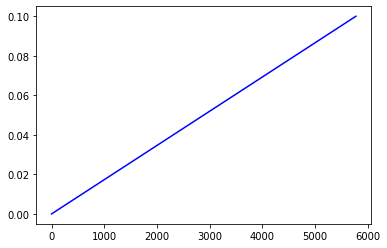

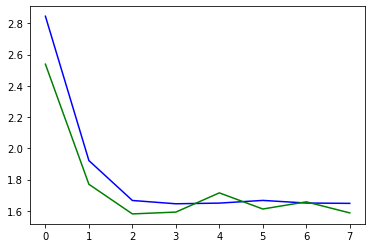

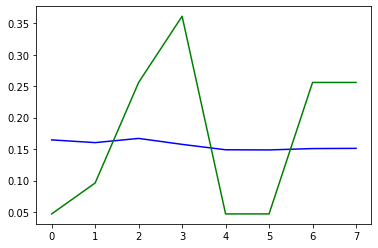

In [0]:
import matplotlib.pyplot as plt

def plot_pairs(metric, val_metric):
  plt.plot(range(len(metric)), metric, color='blue')
  plt.plot(range(len(val_metric)), val_metric, color='green')
  plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plot_pairs(clr.history['lr'], [])
plot_pairs(loss, val_loss)
plot_pairs(acc, val_acc)